In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import soaplite
import soaputils as su
import genBasis
import ase
from ase.visualize import view
from ase.build import bulk
import numpy as np
from numpy.linalg import svd
import matplotlib as matplotlib
import matplotlib.pyplot as p
import numpy.linalg as nl
from scipy.optimize import fmin
import scipy.optimize as op
from scipy.spatial.distance import cdist
import time
%matplotlib notebook

In [2]:
rCut = 10.0
NradBas = 5
Lmax = 5
myAlphas, myBetas = genBasis.getBasisFunc(rCut, NradBas)

struct1 = ase.io.read(currentdir + "/glass_cube_CuZr.cfg")
mat1 = soaplite.get_periodic_soap_structure(struct1, myAlphas, myBetas, rCut, NradBas, Lmax)

struct2 = bulk('Cu', 'fcc', a=3.6, cubic=True)
struct2 = soaplite._get_supercell(struct2, rCut=2.0)
mat2 = soaplite.get_periodic_soap_structure(struct2, myAlphas, myBetas, rCut, NradBas, Lmax)

a0 = 4.0
c0 = 1*a0
struct3 = bulk('Au', 'fcc', a=a0, cubic=True)
struct3.set_cell(np.diag((a0,a0,c0)), scale_atoms=True)
struct3.set_chemical_symbols(('Au','Cu','Cu','Au'))
struct3 = soaplite._get_supercell(struct3, rCut=2.0)
mat3 = soaplite.get_periodic_soap_structure(struct3, myAlphas, myBetas, rCut, NradBas, Lmax)

#p.matshow(mat1)
#p.matshow(mat3)

526.6094264044694
90


<IPython.core.display.Javascript object>


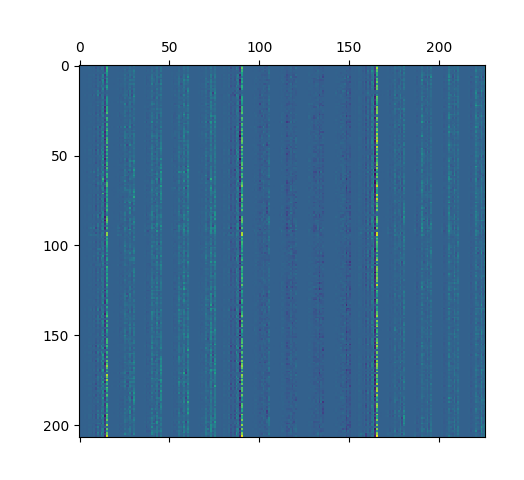

131.6850887322522


In [3]:
# calculates the 'block norm'
order = 2
mat0 = mat1
struct0 = struct1.copy()
print(nl.norm(mat0, ord=order))
symbols = struct0.get_chemical_symbols()
uSym = len(np.unique(symbols))
numBlocks = int(uSym*(uSym + 1)/2)
rowsBlock = int(np.shape(mat1)[1]/numBlocks)
print(rowsBlock)
mat = np.zeros((np.shape(mat0)[0],1))
frac = 0.17
sumNorm = 0.0
for i in np.arange(numBlocks):
    mat = np.append(mat,mat0[:,i*rowsBlock+int(frac*rowsBlock):(i+1)*rowsBlock],axis=1)
    #mat = mat1[:,i*rowsBlock:(i+1)*rowsBlock]
    #sumNorm += np.power(nl.norm(mat[:,int(frac*rowsBlock):],ord=order),order)
#sumNorm = np.power(sumNorm,1/ord)
p.matshow(mat)
print(nl.norm(mat,ord=order))

Number of Atoms: 30
Singular-Value norm: 318.855584
Full Matrix norm: 154.444932
Block matrix norm: 57.275697


<IPython.core.display.Javascript object>


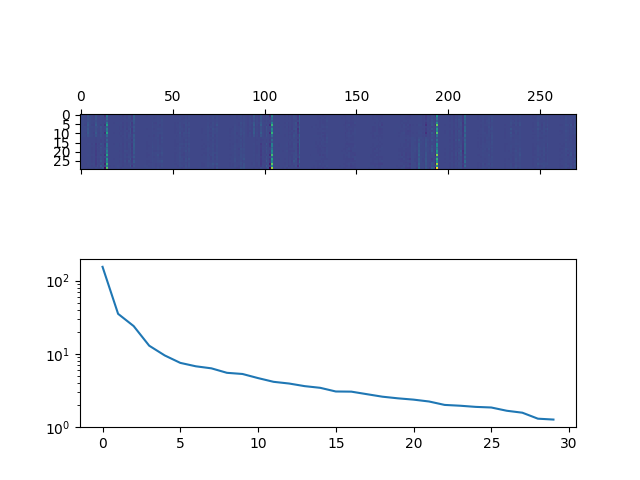

Time passed: 97.151615 s
Iterations: 104
Singular-Value norm: 2928.256666
Full Matrix norm: 1931.507058
Block matrix norm: 502.159067


<IPython.core.display.Javascript object>


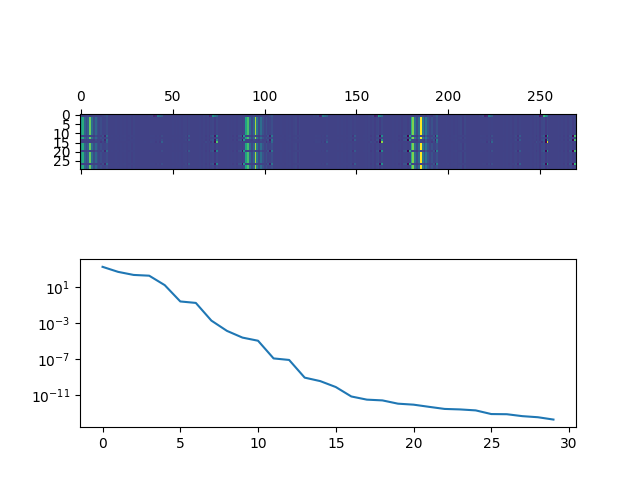

In [4]:
# optimization with matrix-norm as function and unit cell as bounds
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='L-BFGS-B',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, True),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

Number of Atoms: 30
Singular-Value norm: 318.855584
Full Matrix norm: 154.444932
Block matrix norm: 58.330905


<IPython.core.display.Javascript object>


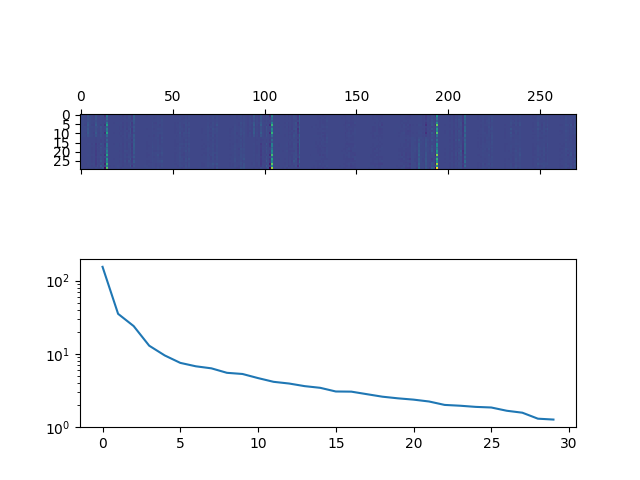

Time passed: 438.133229 s
Iterations: 70
Singular-Value norm: 84.661011
Full Matrix norm: 51.188503
Block matrix norm: 4.436407


<IPython.core.display.Javascript object>


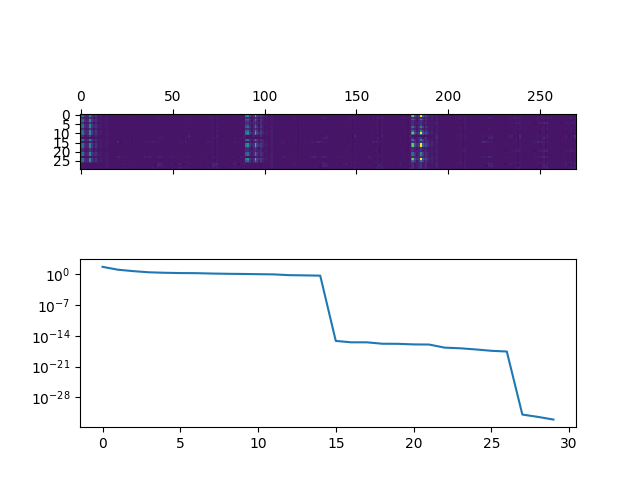

In [5]:
# optimization with block-norm as function and unit cell as bounds
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
periodic = False
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.norm_block, x0, method='L-BFGS-B',args=(atoms_test, 2, 0.3, myAlphas, myBetas, rCut, NradBas, Lmax, periodic),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=periodic)

In [6]:
atoms_test.set_positions(np.reshape(xopt,(30,3)))
view(atoms_test)
print(atoms_test.get_positions())

[[ 0.          4.05519779  0.        ]
 [10.          0.          0.        ]
 [ 0.         10.          5.60181073]
 [10.          0.         10.        ]
 [ 0.          0.          0.        ]
 [ 0.          3.12633869  0.        ]
 [10.          0.          0.        ]
 [10.          0.          0.        ]
 [ 0.          0.         10.        ]
 [10.          0.         10.        ]
 [10.         10.         10.        ]
 [ 0.          0.         10.        ]
 [ 0.         10.         10.        ]
 [ 0.         10.         10.        ]
 [10.          0.         10.        ]
 [10.         10.          0.        ]
 [ 0.          0.         10.        ]
 [ 0.          5.70860522  0.        ]
 [10.         10.          0.        ]
 [10.          0.          0.        ]
 [10.         10.         10.        ]
 [10.         10.          0.        ]
 [10.         10.          0.        ]
 [ 0.          0.          0.        ]
 [10.          0.          0.        ]
 [10.          0.        

Number of Atoms: 30
Singular-Value norm: 331.524539
Full Matrix norm: 151.530283
Block matrix norm: 55.428532


<IPython.core.display.Javascript object>


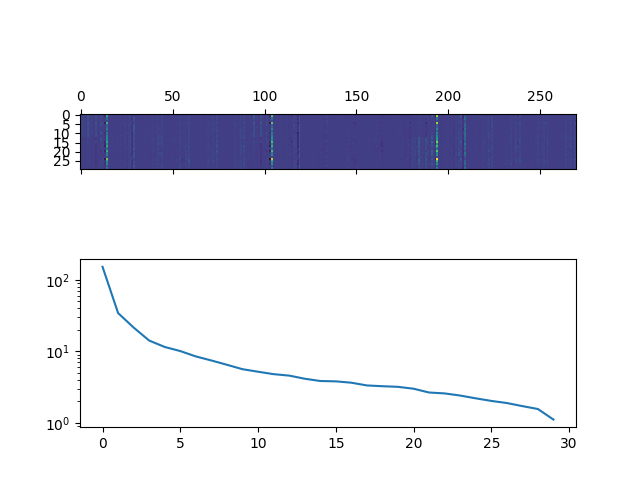

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 72.7686832445447
            Iterations: 42
            Function evaluations: 3892
            Gradient evaluations: 42
Time passed: 24.664568 s
Iterations: 42
Singular-Value norm: 169.534392
Full Matrix norm: 68.086787
Block matrix norm: 39.193810


<IPython.core.display.Javascript object>


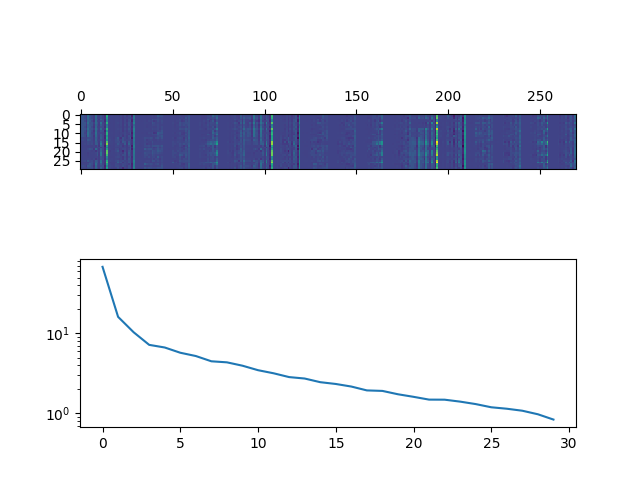

In [7]:
# unconstrained SLSQP optimization
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, 3)
view(atoms_test)

x0 = atoms_test.get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='SLSQP',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, False),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [8]:
dist1 = struct1.get_all_distances(mic=False)
x = struct1.get_positions()
dist2 = cdist(x,x)

In [9]:
rmin = 5
def cons(x):
    x = np.reshape(x,(-1,3))
    dist = cdist(x,x)
    np.fill_diagonal(dist,10.0)
    dist = np.reshape(dist,(-1,))
    amin = np.amin(dist)
    dist[:] = [x-amin-rmin for x in dist]
    return dist
ineq_cons = {'type': 'ineq', 'fun': lambda x:  cons(x)}

Number of Atoms: 30
Minimal pair-distance: 1.802927
Singular-Value norm: 352.936959
Full Matrix norm: 159.984076
Block matrix norm: 54.025626


<IPython.core.display.Javascript object>


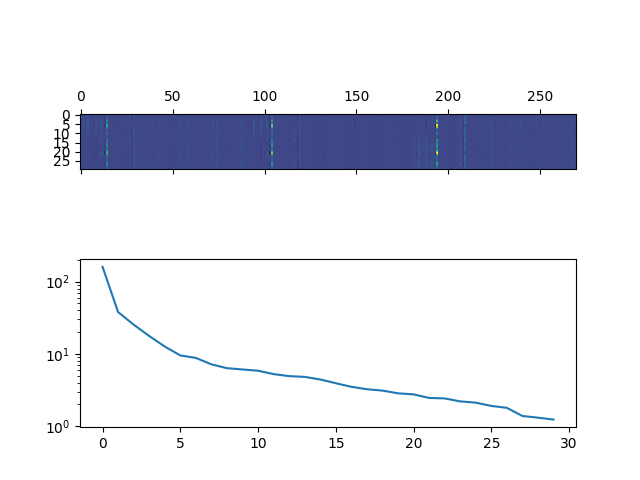

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 74.14594093125669
            Iterations: 118
            Function evaluations: 10764
            Gradient evaluations: 114
Time passed: 72.471184 s
Iterations: 118
Minimal pair-distance: 0.000000
Singular-Value norm: 170.964970
Full Matrix norm: 69.628560
Block matrix norm: 39.577332


<IPython.core.display.Javascript object>


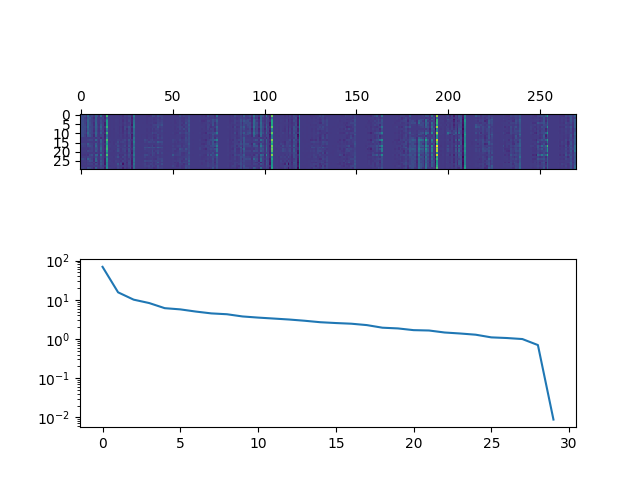

In [10]:
# CONSTRAINED SLSQP optimization
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, rmin)
#view(atoms_test)

x0 = atoms_test.get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
dist = atoms_test.get_all_distances(mic=True)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print('Minimal pair-distance: %f' %amin)
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='SLSQP',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, False), constraints=ineq_cons, bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)

xopt = res_obj.x
atoms_res = atoms_test.copy()
atoms_res.set_positions(np.reshape(xopt,(-1,3)))
dist = atoms_test.get_all_distances(mic=True)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print('Minimal pair-distance: %f' %amin)
su.show_res(atoms_res, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [11]:
atoms_test.set_positions(np.reshape(xopt,(-1,3)))
view(atoms_test)

In [12]:
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, rmin)
view(atoms_test)
x = atoms_test.get_positions()
x = np.reshape(x,(-1,1))
dist = atoms_test.get_all_distances(mic=True)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print(amin)

1.8041653307061178
